# FINAL TASK PBI HOME CREDIT INDONESIA

## Project Problem Statement
The current loan approval process lacks effective risk assessment, resulting in a high number of bad clients and significant revenue loss

## Project Goals
Reduce default rate through data-driven client assessment using machine learning.

## Project Objectives
Build and deploy a predictive model to identify high-risk clients before loan approval.

## Business Metrics
Default Rate Reduction (%)

Increase in Net Revenue ($)

Model Accuracy / Recall on Bad Clients (%)

Cost Saved from Bad Loans ($)

## Import Library

In [ ]:
!pip install toad

   ---------------------------------------- 0.0/14.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/14.2 MB 1.9 MB/s eta 0:00:08
   -- ------------------------------------- 0.8/14.2 MB 1.9 MB/s eta 0:00:08
   --- ------------------------------------ 1.3/14.2 MB 2.0 MB/s eta 0:00:07
   ----- ---------------------------------- 1.8/14.2 MB 2.0 MB/s eta 0:00:07
   ----- ---------------------------------- 2.1/14.2 MB 2.0 MB/s eta 0:00:07
   ------- -------------------------------- 2.6/14.2 MB 2.0 MB/s eta 0:00:06
   -------- ------------------------------- 2.9/14.2 MB 2.0 MB/s eta 0:00:06
   --------- ------------------------------ 3.4/14.2 MB 2.0 MB/s eta 0:00:06
   ----------- ---------------------------- 3.9/14.2 MB 2.1 MB/s eta 0:00:06
   ------------ --------------------------- 4.5/14.2 MB 2.1 MB/s eta 0:00:05
   ------------- -------------------------- 5.0/14.2 MB 2.2 MB/s eta 0:00:05
   ----------

In [ ]:
!pip install shap

   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   -------------------------------------- - 524.3/545.2 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 545.2/545.2 kB 1.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import toad
from toad.metrics import KS, AUC
from toad.plot import bin_plot, badrate_plot
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
import shap

## Load Cleaned Data

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Membaca file Parquet
df_train_full = pd.read_parquet('df_train_full.parquet')

In [ ]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Columns: 105 entries, SK_ID_CURR to AVERAGE_DPD
dtypes: float64(54), int64(21), object(30)
memory usage: 1.1+ GB


In [ ]:
pd.set_option('display.max_columns', None)

# Pilih kolom-kolom bertipe objek dan simpan dalam variabel 'categoric'
categoric = df_train_full.select_dtypes('object')

# Pilih kolom-kolom bertipe numerik dan simpan dalam variabel 'numeric'
numeric = df_train_full.select_dtypes('number')

# Tentukan jumlah baris dan kolom
rows = df_train_full.shape[0]
cols = df_train_full.shape[1]

# Cetak bentuk DataFrame
print(f'Jumlah Baris: {rows}\nJumlah Kolom: {cols}')

# Cetak sampel 6 baris dari DataFrame
print('\nContoh Data:')
display(df_train_full.sample(6))

# Cetak ringkasan statistik data kategorikal
print('\nRingkasan Statistik Data Kategorikal:')
display(categoric.describe().T)

# Cetak ringkasan statistik data numerik
print('\nRingkasan Statistik Data Numerik:')
display(numeric.describe().T)

# Define categorical_col and numerical_col before printing
categorical_col = categoric.columns.tolist()  # Get the list of categorical columns
numerical_col = numeric.columns.tolist()    # Get the list of numerical columns

Jumlah Baris: 1430155
Jumlah Kolom: 105

Contoh Data:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,MEAN_BUREAU_STATUS,STATUS_BIN,AVG_DAYS_OVERDUE,DEBT_CREDIT_RATIO,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE_prev,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD
924345,330944,0,Cash loans,M,Y,N,1,225000.0,755190.0,36459.0,675000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.008866,-10502,-1878,-4756.0,-2766,1,1,0,1,0,0,Laborers,3.0,2,2,THURSDAY,10,0,0,0,0,0,0,Industry: type 8,0.214423,0.754406,0.9866,0.3333,0.9866,0.3333,0.9866,0.3333,0.0578,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3342232.800,0.000,0.483923,light_late,0.0,0.000000,1101670.0,Consumer loans,7514.235,75150.0,67635.0,7515.0,75150.0,FRIDAY,17.0,Y,1.0,0.108909,XAP,Approved,-1469.0,Cash through the bank,XAP,Unaccompanied,New,Computers,POS,XNA,Stone,92.0,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1435.0,-1165.0,-1165.0,-1159.0,0.0,75129.345,75129.345,0.0,0.0
649307,262482,0,Cash loans,F,N,Y,0,135000.0,334152.0,17190.0,270000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.019689,-21162,365243,-7287.0,-3367,1,0,0,1,0,0,Laborers,2.0,2,2,FRIDAY,14,0,0,0,0,0,0,XNA,0.337226,0.738020,0.9742,0.0417,0.9727,0.0417,0.9742,0.0417,0.0052,No,2.0,1.0,2.0,1.0,-1751.0,0.0,0.0,0.0,0.0,0.0,8.0,1126075.680,491222.295,1.060606,moderate_late,0.0,0.436225,1149363.0,Cash loans,11250.000,0.0,0.0,0.0,112320.0,WEDNESDAY,10.0,Y,1.0,0.000000,XNA,Canceled,-261.0,XNA,XAP,Unknown,Repeater,XNA,XNA,XNA,Credit and cash offices,0.0,XNA,12.0,XNA,Cash,365243.0,-831.0,-361.0,-537.0,-499.0,0.0,0.000,0.000,0.0,NaN
1394107,447329,0,Cash loans,F,N,N,0,162000.0,585000.0,46219.5,585000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.009549,-17559,-606,-11637.0,-830,1,1,1,1,1,0,Sales staff,2.0,2,2,SUNDAY,12,0,0,0,0,0,0,Business Entity Type 3,0.554060,0.259468,0.9836,0.5417,0.9782,0.4583,0.9836,0.5417,0.0651,No,0.0,0.0,0.0,0.0,-285.0,0.0,0.0,0.0,1.0,0.0,2.0,1907685.000,616474.530,1.000000,light_late,0.0,0.323153,1391484.0,Cash loans,11250.000,0.0,0.0,0.0,112320.0,THURSDAY,13.0,Y,1.0,0.000000,XNA,Canceled,-263.0,XNA,XAP,Unknown,Repeater,XNA,XNA,XNA


Ringkasan Statistik Data Kategorikal:


,count,unique,top,freq
NAME_CONTRACT_TYPE_curr,1430155,2,Cash loans,1320679
CODE_GENDER,1430155,3,F,964822
FLAG_OWN_CAR,1430155,2,N,947544
FLAG_OWN_REALTY,1430155,2,Y,1031672
NAME_TYPE_SUITE_curr,1430155,7,Unaccompanied,1171310
NAME_INCOME_TYPE,1430155,8,Working,730613
NAME_EDUCATION_TYPE,1430155,5,Secondary / secondary special,1046822
NAME_FAMILY_STATUS,1430155,6,Married,921040
NAME_HOUSING_TYPE,1430155,6,House / apartment,1279761
OCCUPATION_TYPE,1430155,18,Laborers,716492



Ringkasan Statistik Data Numerik:


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1430155.0,278470.247890,102802.095340,100002.0,189361.0,278956.00,367509.000,4.562550e+05
TARGET,1430155.0,0.086242,0.280722,0.0,0.0,0.00,0.000,1.000000e+00
CNT_CHILDREN,1430155.0,0.403887,0.716518,0.0,0.0,0.00,1.000,1.900000e+01
AMT_INCOME_TOTAL,1430155.0,173603.622588,198330.285287,25650.0,112500.0,157500.00,211500.000,1.170000e+08
AMT_CREDIT_curr,1430155.0,589338.592951,387420.355419,45000.0,270000.0,508495.50,808650.000,4.050000e+06
...,...,...,...,...,...,...,...,...
NFLAG_INSURED_ON_APPROVAL,1413701.0,0.199366,0.399524,0.0,0.0,0.00,0.000,1.000000e+00
AMT_INSTALMENT,1413701.0,135133.806580,280811.736748,0.0,0.0,37148.22,136007.100,1.934759e+07
AMT_PAYMENT,1413701.0,136538.978006,300142.070809,0.0,0.0,36030.42,131706.945,1.934759e+07
DIFF_INSTALLMENT_PAYMENT,1413701.0,-1405.171426,73348.780934,-3195000.0,0.0,0.00,0.000,2.602349e+06


In [ ]:
print("Categorical columns: ", categorical_col)
print("Numerical columns: ", numerical_col)

Categorical columns:  ['NAME_CONTRACT_TYPE_curr', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE_curr', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_curr', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE', 'STATUS_BIN', 'NAME_CONTRACT_TYPE_prev', 'WEEKDAY_APPR_PROCESS_START_prev', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE_prev', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']
Numerical columns:  ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_curr', 'AMT_ANNUITY_curr', 'AMT_GOODS_PRICE_curr', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_C

## **EDA**

### **Check Missing Value**

In [ ]:
# Memeriksa baris duplikat
duplicate_rows = df_train_full.duplicated()

# Menampilkan jumlah baris duplikat
print(f"Jumlah baris duplikat: {duplicate_rows.sum()}")

# Fungsi untuk menghitung dan menampilkan kolom dengan nilai missing
def check_nan(df_train_full):
    # Hitung nilai null
    null_values = df_train_full.isnull().sum()

    # Buat DataFrame untuk total nilai null dan persentase
    nvc = pd.DataFrame(null_values[null_values > 0].sort_values(), columns=['Total Null Values'])  # Hanya ambil kolom dengan nilai null
    nvc['Percentage'] = (nvc['Total Null Values'] / df_train_full.shape[0]) * 100
    nvc["Data Type"] = [df_train_full[col].dtype for col in nvc.index]  # Ambil tipe data dari kolom yang ada

    # Urutkan berdasarkan total nilai null dan persentase
    nvc.sort_values(by=["Total Null Values", "Percentage"], ascending=False, inplace=True)

    # Tampilkan hasil dengan gaya
    return nvc.style.background_gradient(cmap='Blues')

# Panggil fungsi dan simpan hasilnya
styled_result = check_nan(df_train_full)

# Untuk menampilkan hasil di Jupyter Notebook, gunakan:
styled_result

Jumlah baris duplikat: 0


,Total Null Values,Percentage,Data Type
AVERAGE_DPD,660541,46.186672,float64
STATUS_BIN,175487,12.270488,object
NAME_CLIENT_TYPE,16454,1.150505,object
NAME_GOODS_CATEGORY,16454,1.150505,object
NAME_PORTFOLIO,16454,1.150505,object
NAME_PRODUCT_TYPE,16454,1.150505,object
CHANNEL_TYPE,16454,1.150505,object
SELLERPLACE_AREA,16454,1.150505,float64
NAME_SELLER_INDUSTRY,16454,1.150505,object
CNT_PAYMENT,16454,1.150505,float64


**Kolom AVERAGE_DPD (missing ~46%)**

* Wajar, kemungkinan karena banyak klien tidak punya riwayat keterlambatan pembayaran atau tidak punya aplikasi sebelumnya.

* Missing-nya punya makna, biarkan missing sebagai informasi.

**Kolom lain (missing <12.3%)**

* Proporsi missing rendah, biarkan missing, nanti saat WOE binning dianggap kategori khusus.

### **Handle invalid values**

In [ ]:
train_full = df_train_full

# x train categorical value binning
train_full['AGE'] = round(abs(train_full['DAYS_BIRTH'] / 365.25)).astype(int)

def age_group(age):
    if age < 30:
        return 'Young'
    elif 30 <= age <= 44:
        return 'Adult'
    elif 45 <= age <= 59:
        return 'Middle_Age'
    else:
        return 'Senior'

train_full['AGE_GROUP'] = train_full['AGE'].apply(age_group)


train_full = train_full[train_full.NAME_FAMILY_STATUS != 'Unknown']

# make a function to replace columns value contains XNA or XAP with np.nan
def replace_xna_xap(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].replace(['XNA', 'XAP'], np.nan)
    return df

train_full = replace_xna_xap(train_full)

# replace abnormal value
replace_val = {4.5 : 5,
               0.5 : 1}
train_full['CNT_FAM_MEMBERS'] = train_full['CNT_FAM_MEMBERS'].replace(replace_val)

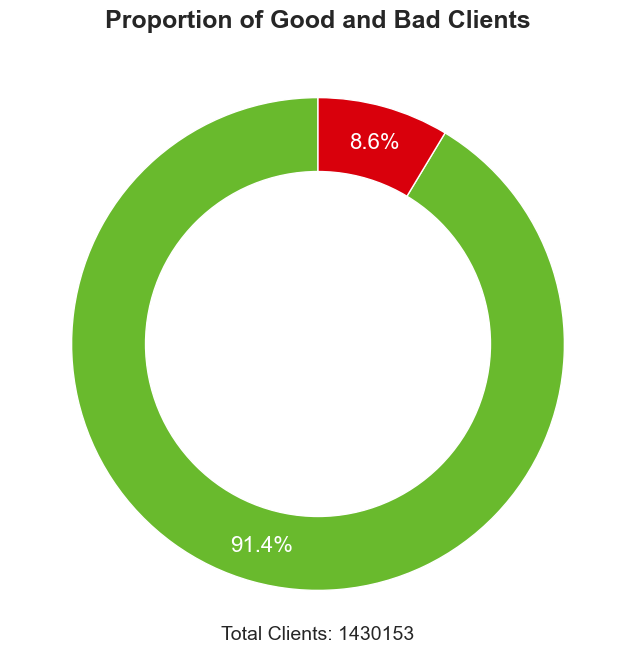

In [ ]:
# Data
counts = train_full['TARGET'].value_counts(normalize=True)
labels = ['Good Clients', 'Bad Clients']
colors = ['#69ba2d', '#d9000c']

# Pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(counts, labels=labels, colors=colors,
                                  autopct='%1.1f%%', startangle=90, pctdistance=0.85,
                                  textprops={'color': 'white', 'fontsize': 16})

# Donut hole
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Title
plt.title('Proportion of Good and Bad Clients', fontsize=18, fontweight='bold')
plt.text(0, -1.2, f"Total Clients: {train_full.shape[0]}", fontsize=14, ha='center')

plt.show()

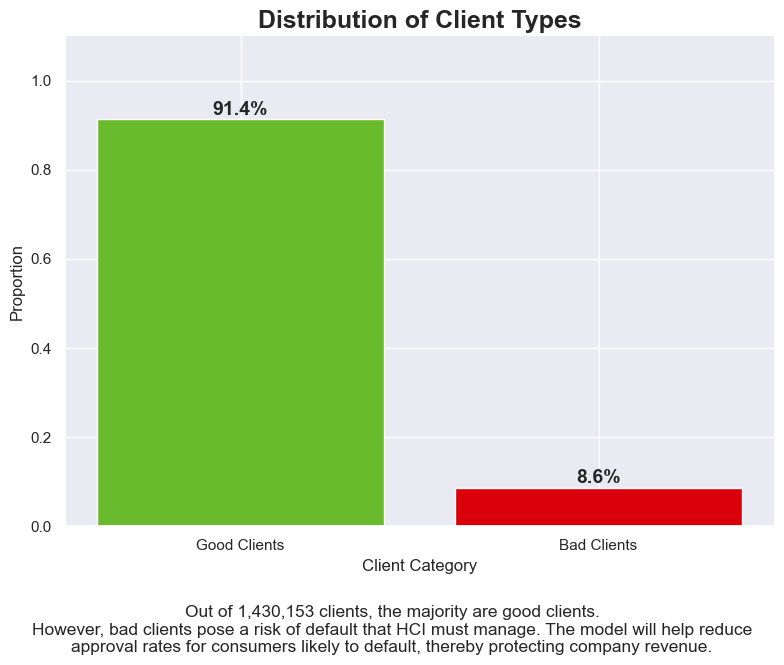

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = train_full['TARGET'].value_counts(normalize=True)
total_clients = train_full.shape[0]

# Warna dan label
colors = ['#69ba2d', '#d9000c']
labels = ['Good Clients', 'Bad Clients']

# Setup plot
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.bar(labels, counts.values, color=colors)
sns.despine()

# Tambahkan persentase di atas bar
for i, v in enumerate(counts.values):
    ax.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=14)

# Judul & narasi
plt.title('Distribution of Client Types', fontsize=18, fontweight='bold')
plt.xlabel('Client Category')
plt.ylabel('Proportion')
plt.ylim(0, 1.1)

# Insight text (di luar grafik)
plt.figtext(0.5, -0.1,
    f"Out of {total_clients:,} clients, the majority are good clients.\n"
    "However, bad clients pose a risk of default that HCI must manage. The model will help reduce\n"
    "approval rates for consumers likely to default, thereby protecting company revenue.",
    ha='center', fontsize=12.5)

plt.tight_layout()
plt.show()


## **Train Test Split**

In [ ]:
print(train_full['TARGET'].value_counts())


TARGET
0    1306813
1     123340
Name: count, dtype: int64


In [ ]:
X = train_full.drop(columns='TARGET')
y = train_full[['TARGET']]  # ubah jadi Series, bukan DataFrame

# Train-test split dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1072614, 106) (357539, 106) (1072614, 1) (357539, 1)


In [ ]:
y

,TARGET
0,1
1,0
2,0
3,0
4,0
...,...
1430150,0
1430151,0
1430152,0
1430153,0


## Data filtering

In [ ]:
toad.quality(X_train, target=y_train['TARGET'], iv_only=True)

,iv,gini,entropy,unique
EXT_SOURCE_3,3.665517e-01,NaN,NaN,813.0
EXT_SOURCE_2,2.919930e-01,NaN,NaN,116399.0
DAYS_EMPLOYED,1.002460e-01,NaN,NaN,12413.0
AMT_GOODS_PRICE_curr,9.238380e-02,NaN,NaN,976.0
DEBT_CREDIT_RATIO,7.975067e-02,NaN,NaN,173463.0
...,...,...,...,...
NFLAG_LAST_APPL_IN_DAY,1.393372e-04,NaN,NaN,3.0
FLAG_MOBIL,2.310817e-05,NaN,NaN,2.0
FLAG_EMAIL,2.060958e-05,NaN,NaN,2.0
EMERGENCYSTATE_MODE,7.441213e-06,NaN,NaN,2.0


In [ ]:
Xtrain_selected, drop_list = toad.selection.select(
    frame=X_train,
    target=y_train['TARGET'],
    empty=0.5,   # hapus kolom dengan missing value >50%
    iv=0.02,     # hapus kolom dengan IV <0.02 (tidak informatif)
    corr=0.7,    # hapus kolom yang korelasinya >0.7 dengan kolom lain
    return_drop=True
)

print("Fitur yang dipilih:", Xtrain_selected.shape[1])
print("Drop empty (missing >50%):", len(drop_list['empty']))
print("Drop IV (IV < 0.02):", len(drop_list['iv']))
print("Drop corr (corr > 0.7):", len(drop_list['corr']))

print("\nList fitur yang di-drop:")
for key, val in drop_list.items():
    print(f"{key}: {val}")

print("\nFitur akhir yang dipakai untuk modeling:")
display(Xtrain_selected)

Fitur yang dipilih: 34
Drop empty (missing >50%): 5
Drop IV (IV < 0.02): 56
Drop corr (corr > 0.7): 11

List fitur yang di-drop:
empty: ['NAME_CASH_LOAN_PURPOSE' 'CODE_REJECT_REASON' 'NAME_GOODS_CATEGORY'
 'NAME_PRODUCT_TYPE' 'NAME_SELLER_INDUSTRY']
iv: ['SK_ID_CURR' 'NAME_CONTRACT_TYPE_curr' 'FLAG_OWN_CAR' 'FLAG_OWN_REALTY'
 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'NAME_TYPE_SUITE_curr'
 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE' 'FLAG_MOBIL' 'FLAG_WORK_PHONE'
 'FLAG_CONT_MOBILE' 'FLAG_PHONE' 'FLAG_EMAIL' 'CNT_FAM_MEMBERS'
 'WEEKDAY_APPR_PROCESS_START_curr' 'HOUR_APPR_PROCESS_START_curr'
 'REG_REGION_NOT_LIVE_REGION' 'REG_REGION_NOT_WORK_REGION'
 'LIVE_REGION_NOT_WORK_REGION' 'REG_CITY_NOT_LIVE_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'EMERGENCYSTATE_MODE'
 'OBS_30_CNT_SOCIAL_CIRCLE' 'DEF_30_CNT_SOCIAL_CIRCLE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'DEF_60_CNT_SOCIAL_CIRCLE'
 'AMT_REQ_CREDIT_BUREAU_HOUR' 'AMT_REQ_CREDIT_BUREAU_DAY'
 'AMT_REQ_CREDIT_BUREAU_WEEK' 'AMT_REQ_CREDIT_BUREAU_MON'
 'AMT_REQ_CREDIT_BUREA

,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,MEAN_BUREAU_STATUS,DEBT_CREDIT_RATIO,AMT_DOWN_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,AMT_PAYMENT,AVERAGE_DPD,AGE_GROUP
1016973,M,675000.0,Working,Secondary / secondary special,0.032561,-18346,-186,-4299.0,-1775,Laborers,1,0,Business Entity Type 3,0.686208,0.413597,0.1404,0.9955,0.0837,-1630.0,634275.000,0.000000,0.145853,9000.0,Approved,-1630.0,10.0,high,POS mobile with interest,-1555.0,-1285.0,-1315.0,95423.355,0.0,Middle_Age
513737,M,283500.0,Working,Higher education,0.035792,-15225,-1476,-7759.0,-2177,Managers,2,0,Trade: type 3,0.744670,0.286652,0.1250,0.9767,0.0401,-1840.0,1016154.000,0.893333,0.482493,15709.5,Approved,-2524.0,10.0,low_normal,POS household with interest,-2493.0,-2223.0,-2223.0,168438.195,0.0,Adult
775895,F,675000.0,Pensioner,Secondary / secondary special,0.015221,-20555,365243,-3068.0,-3989,Laborers,2,0,NaN,0.519498,0.651260,0.1667,0.9752,0.0561,0.0,393529.500,0.000000,0.296467,0.0,Approved,-1112.0,12.0,low_normal,POS household with interest,-1081.0,-751.0,-901.0,154144.620,0.0,Middle_Age
1396012,F,225000.0,Commercial associate,Higher education,0.010500,-10300,-2577,-854.0,-2600,Sales staff,3,0,Self-employed,0.540249,0.746300,0.3750,0.9980,0.1061,-1676.0,0.000,0.000000,0.000000,2250.0,Approved,-1676.0,6.0,high,POS household with interest,-1645.0,-1495.0,-1555.0,27591.660,0.0,Young
43190,M,270000.0,Working,Secondary / secondary special,0.018634,-9879,-1827,-404.0,-2519,Laborers,2,0,Transport: type 2,0.291692,0.032748,0.0833,0.9727,0.0160,-538.0,3729053.925,0.000000,0.690645,0.0,Refused,-74.0,12.0,NaN,Cash,-831.0,-361.0,-537.0,0.000,NaN,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19657,M,225000.0,Commercial associate,Secondary / secondary special,0.015221,-10958,-814,-1028.0,-3634,Drivers,2,0,Self-employed,0.147503,0.553165,0.1667,0.9771,0.0931,-1524.0,1100493.000,0.000000,0.424193,0.0,Approved,-72.0,12.0,middle,POS mobile with interest,-39.0,291.0,365243.0,4328.370,0.0,Adult
92916,F,337500.0,Pensioner,Secondary / secondary special,0.019689,-23312,365243,-7513.0,-3209,Laborers,2,0,NaN,0.228012,0.163426,0.1667,0.9861,0.0829,-569.0,81544.500,0.000000,0.419954,0.0,Approved,-569.0,36.0,low_normal,POS household with interest,-530.0,520.0,365243.0,93303.225,0.0,Senior
1423734,F,90000.0,Working,Secondary / secondary special,0.028663,-14225,-951,-1578.0,-2897,Laborers,2,0,Government,0.350612,0.524496,0.1667,0.9836,0.0719,-266.0,37143.000,0.662981,0.094759,0.0,Canceled,-376.0,12.0,NaN,Cash,-831.0,-361.0,-537.0,0.000,NaN,Adult
225493,F,981000.0,Working,Secondary / secondary special,0.020246,-14990,-2015,-7566.0,-4396,Laborers,3,0,Business Entity Type 3,0.354200,0.634706,0.1667,0.9816,0.0688,-948.0,227124.000,0.797500,0.373025,14355.0,Refused,-693.0,12.0,middle,POS household with interest,-831.0,-361.0,-537.0,0.000,NaN,Adult


In [ ]:
selected_features = Xtrain_selected.columns

X_test = X_test[selected_features]

In [ ]:
# output the iv table to a dataframe
def iv_importance(data_selected, label):
    iv_import_feat = toad.quality(data_selected, label, iv_only=True)
    iv_import_feat = iv_import_feat['iv']
    iv_import_feat = iv_import_feat.reset_index()
    iv_import_feat.columns = ['name', 'iv']
    return iv_import_feat

df_iv = iv_importance(Xtrain_selected, y_train['TARGET'])

df_iv.sort_values(by='iv', ascending=False)

,name,iv
0,EXT_SOURCE_3,0.366552
1,EXT_SOURCE_2,0.291993
2,DAYS_EMPLOYED,0.100246
3,AMT_GOODS_PRICE_curr,0.092384
4,DEBT_CREDIT_RATIO,0.079751
5,DAYS_BIRTH,0.077698
6,ORGANIZATION_TYPE,0.070162
7,AGE_GROUP,0.064002
8,NAME_INCOME_TYPE,0.057185
9,DAYS_LAST_PHONE_CHANGE,0.057074


In [ ]:
corr = train_full[['EXT_SOURCE_2', 'EXT_SOURCE_3']].corr()
print(corr)

              EXT_SOURCE_2  EXT_SOURCE_3
EXT_SOURCE_2      1.000000      0.094273
EXT_SOURCE_3      0.094273      1.000000


## Handling Outlier

In [ ]:
def cap_outliers(data, columns):
    # Create a copy of the data to avoid modifying the original DataFrame
    result = data.copy()

    # Loop over each column in the provided list
    for col in columns:
        # Calculate the first quartile (Q1) for the current column
        Q1 = result[col].quantile(0.25)
        # Calculate the third quartile (Q3) for the current column
        Q3 = result[col].quantile(0.75)
        # Calculate the Interquartile Range (IQR) for the current column
        IQR = Q3 - Q1
        # Calculate the lower bound for the current column
        lower_bound = Q1 - (1.5 * IQR)
        # Calculate the upper bound for the current column
        upper_bound = Q3 + (1.5 * IQR)
        # Replace values in the current column that are less than the lower bound with the lower bound
        result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
        # Replace values in the current column that are greater than the upper bound with the upper bound
        result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
    # Return the DataFrame with capped outliers
    return result


# Select the names of all numerical columns in the DataFrame X_train_c2
outliers = Xtrain_selected.select_dtypes(include='number').columns

# Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# This will cap the outliers in these columns, and the result is stored in X_train_c3
Xtrain_selected = cap_outliers(Xtrain_selected, outliers)

## Feature Binning

In [ ]:
# combine x_train and y_train
train = pd.concat([Xtrain_selected, y_train], axis=1)
sample = train.sample(frac=0.25, random_state=1103)

c = toad.transform.Combiner()
c.fit(X=sample.drop('TARGET', axis=1), y=sample['TARGET'], method='dt', n_bins=None, empty_separate=True)

In [ ]:
bins_output = c.export()
bins_output

{'CODE_GENDER': [['nan'], ['F'], ['M']],
 'AMT_GOODS_PRICE_curr': [137250.0,
  299250.0,
  422106.75,
  452250.0,
  467937.0,
  627750.0,
  675191.25,
  677889.0,
  692957.25],
 'NAME_INCOME_TYPE': [['Pensioner'],
  ['State servant'],
  ['Commercial associate'],
  ['Working'],
  ['Student', 'Businessman'],
  ['Unemployed'],
  ['Maternity leave']],
 'NAME_EDUCATION_TYPE': [['Academic degree'],
  ['Higher education'],
  ['Incomplete higher'],
  ['Secondary / secondary special'],
  ['Lower secondary']],
 'REGION_POPULATION_RELATIVE': [0.002319999970495701,
  0.017320500686764717,
  0.018825500272214413,
  0.019967499189078808,
  0.020479499362409115,
  0.025778000243008137,
  0.027527499943971634,
  0.0319449994713068,
  0.05141475051641464],
 'DAYS_BIRTH': [-23955.5,
  -20742.5,
  -20738.5,
  -19578.5,
  -16459.5,
  -13865.5,
  -13837.5,
  -11735.5,
  -8591.5],
 'DAYS_EMPLOYED': [-3965.5,
  -3023.5,
  -1721.5,
  -1720.5,
  -1169.5,
  -196.5,
  -189.5,
  -4.5,
  1766.75],
 'DAYS_REGISTRAT

## Transform WoE

In [ ]:
# intialize the WOE transformer
td = toad.transform.WOETransformer()

# Transform the data into WoE values
Xtrain_selected_woe = td.fit_transform(c.transform(Xtrain_selected), y_train['TARGET'])

# transform test set
Xtest_selected_woe = td.fit_transform(c.transform(X_test), y_test['TARGET'])

# Calculate the Information Value (IV) for each feature
iv = toad.quality(Xtrain_selected_woe, y_train['TARGET'], iv_only=True)

iv

,iv,gini,entropy,unique
EXT_SOURCE_3,0.361670,NaN,NaN,10.0
EXT_SOURCE_2,0.285767,NaN,NaN,10.0
DAYS_EMPLOYED,0.097063,NaN,NaN,10.0
AMT_GOODS_PRICE_curr,0.091360,NaN,NaN,10.0
DAYS_BIRTH,0.077349,NaN,NaN,10.0
DEBT_CREDIT_RATIO,0.075668,NaN,NaN,10.0
ORGANIZATION_TYPE,0.068100,NaN,NaN,10.0
AGE_GROUP,0.064002,NaN,NaN,4.0
NAME_INCOME_TYPE,0.057192,NaN,NaN,7.0
DAYS_LAST_PHONE_CHANGE,0.054918,NaN,NaN,10.0


In [ ]:
Xtrain_selected_woe

,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,MEAN_BUREAU_STATUS,DEBT_CREDIT_RATIO,AMT_DOWN_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,AMT_PAYMENT,AVERAGE_DPD,AGE_GROUP
1016973,0.244816,0.143507,0.186770,0.092181,-0.344812,-0.061974,0.242673,0.045761,0.216923,-0.019707,0.0,0.0,0.156745,-0.519278,-0.196914,0.0,-0.233055,-0.263463,-0.185359,0.136029,-0.010236,-0.193808,0.00417,-0.138087,-0.220864,-0.209830,0.111131,0.022658,-0.278862,-0.276265,-0.068882,-0.189511,-0.161203,-0.151069
513737,0.244816,0.031328,0.186770,-0.394028,-0.344812,0.045702,0.177872,-0.130981,0.107213,-0.243241,0.0,0.0,0.365611,-0.933029,0.243474,0.0,-0.035234,-0.017126,-0.326621,0.136029,0.213359,0.088421,0.00417,-0.138087,-0.220864,-0.209830,-0.204658,-0.108545,-0.278862,-0.276265,-0.286537,-0.189511,-0.161203,0.144027
775895,-0.138210,0.143507,-0.419565,0.092181,0.022072,-0.257883,-0.415615,0.045761,-0.050187,-0.019707,0.0,0.0,-0.425174,-0.088768,-0.575855,0.0,-0.035234,-0.017126,0.090520,0.136029,-0.010236,-0.193808,0.00417,-0.138087,-0.136753,0.013380,-0.204658,-0.108545,-0.177095,-0.180899,-0.183435,-0.189511,-0.161203,-0.151069
1396012,-0.138210,0.031328,-0.072578,-0.394028,0.022072,0.321716,-0.014071,0.209659,0.107213,0.150247,0.0,0.0,0.198239,-0.088768,-0.997510,0.0,-0.233055,-0.263463,-0.185359,-0.164376,-0.010236,-0.193808,0.00417,-0.138087,-0.220864,-0.198326,0.111131,-0.108545,-0.278862,-0.276265,-0.286537,-0.026253,-0.161203,0.352502
43190,0.244816,0.031328,0.186770,0.092181,0.287483,0.321716,-0.014071,0.209659,0.107213,-0.019707,0.0,0.0,-0.037038,0.345280,1.862279,0.0,-0.035234,-0.017126,0.248645,0.251689,-0.010236,0.357842,0.00417,0.367876,0.026616,0.013380,0.146538,0.105020,0.191481,0.190097,0.191423,0.169799,0.164095,0.352502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19657,0.244816,0.031328,-0.072578,0.092181,0.022072,0.321716,0.354803,0.045761,-0.050187,0.368774,0.0,0.0,0.198239,0.600039,-0.575855,0.0,-0.035234,-0.263463,-0.185359,0.251689,-0.010236,0.088421,0.00417,-0.138087,0.026616,0.013380,-0.072627,0.022658,-0.168141,-0.139069,-0.060248,0.169799,-0.161203,0.144027
92916,-0.138210,0.288866,-0.419565,0.092181,-0.092371,-0.440097,-0.415615,-0.130981,-0.050187,-0.019707,0.0,0.0,-0.425174,0.600039,0.730331,0.0,-0.233055,-0.263463,0.248645,-0.021601,-0.010236,0.088421,0.00417,-0.138087,0.100816,0.249070,-0.204658,-0.108545,-0.022044,0.096798,-0.060248,-0.189511,-0.161203,-0.522850
1423734,-0.138210,-0.270355,0.186770,0.092181,0.009967,0.045702,0.354803,0.045761,-0.050187,-0.019707,0.0,0.0,-0.165890,0.345280,-0.196914,0.0,-0.233055,-0.263463,0.248645,-0.164376,-0.017024,-0.193808,0.00417,0.062684,0.100816,0.013380,0.146538,0.105020,0.191481,0.190097,0.191423,0.169799,0.164095,0.144027
225493,-0.138210,-0.305473,0.186770,0.092181,0.484009,0.045702,-0.014071,-0.130981,-0.271962,-0.019707,0.0,0.0,0.156745,0.345280,-0.575855,0.0,0.123096,0.133047,0.056663,-0.021601,0.213359,0.088421,0.00417,0.367876,-0.006643,0.013380,-0.072627,-0.108545,0.191481,0.190097,0.191423,0.169799,0.164095,0.144027


In [ ]:
y_train = y_train['TARGET']
y_test = y_test['TARGET']

## Model building

In [ ]:
def get_custom_palette():
    return [
        "#2E2C36",  # Dark Gray / Charcoal
        "#701F1F",  # Dark Red / Maroon
        "#D33A2E",  # Bright Red
        "#FFFFFF",  # White
        "#F2E8DC",  # Warm Beige
        "#E3B505",  # Gold / Mustard
        "#4ECDC4",  # Teal / Soft Cyan
        "#1B9AAA",  # Deep Sky Blue
        "#FF8552",  # Soft Orange Coral
        "#2A9D8F"   # Muted Turquoise Green
    ]

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, fbeta_score, precision_score, confusion_matrix, classification_report, f1_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def eval_model(model, X_train, y_train, X_test, y_test, threshold):
    palette = get_custom_palette()

    model.fit(X_train, y_train)

    pred_train = model.predict_proba(X_train)[:, 1]
    pred_test = model.predict_proba(X_test)[:, 1]

    print('Train AUC:', roc_auc_score(y_train, pred_train))
    print('Test AUC:', roc_auc_score(y_test, pred_test))

    print('Train Recall:', recall_score(y_train, pred_train > threshold))
    print('Test Recall:', recall_score(y_test, pred_test > threshold))

    print('Train Precision:', precision_score(y_train, pred_train > threshold))
    print('Test Precision:', precision_score(y_test, pred_test > threshold))

    print('Train F1-Score:', f1_score(y_train, pred_train > threshold))
    print('Test F1-Score:', f1_score(y_test, pred_test > threshold))

    print('Train F2-Score:', fbeta_score(y_train, pred_train > threshold, beta=2))
    print('Test F2-Score:', fbeta_score(y_test, pred_test > threshold, beta=2))

    print('Train Accuracy:', (y_train == (pred_train > threshold)).mean())
    print('Test Accuracy:', (y_test == (pred_test > threshold)).mean())

    print("\nConfusion Matrix (Test):")
    cm = confusion_matrix(y_test, pred_test > threshold)
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette([palette[1], palette[2]]), xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report (Test):")
    print(classification_report(y_test, pred_test > threshold))

    fpr, tpr, _ = roc_curve(y_test, pred_test)
    roc_auc = roc_auc_score(y_test, pred_test)
    plt.plot(fpr, tpr, color=palette[2], lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color=palette[0], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, pred_test)
    avg_precision = average_precision_score(y_test, pred_test)
    plt.plot(recall, precision, label='Precision-Recall curve (AP = %0.2f)' % avg_precision, color=palette[2])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    df = pd.DataFrame({'pred': pred_test, 'true': y_test})
    df['pred_rank'] = df['pred'].rank(pct=True)
    df['true_positive'] = df['true'] == 1
    lift = df.groupby(pd.cut(df['pred_rank'], bins=np.arange(0, 1.1, 0.1)))['true_positive'].mean()

Train AUC: 0.7413679476247014
Test AUC: 0.7419985380782101
Train Recall: 0.787492567969299
Test Recall: 0.7861845305659153
Train Precision: 0.14177781324261254
Test Precision: 0.1425723241958914
Train F1-Score: 0.24029384017574995
Test F1-Score: 0.24137244359479856
Train F2-Score: 0.4121093285933623
Test F2-Score: 0.4131600385856913
Train Accuracy: 0.570561264350456
Test Accuracy: 0.5737975437644565

Confusion Matrix (Test):


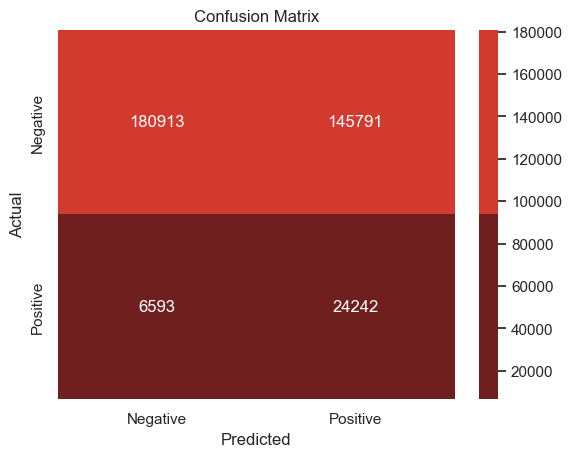


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.55      0.70    326704
           1       0.14      0.79      0.24     30835

    accuracy                           0.57    357539
   macro avg       0.55      0.67      0.47    357539
weighted avg       0.89      0.57      0.66    357539



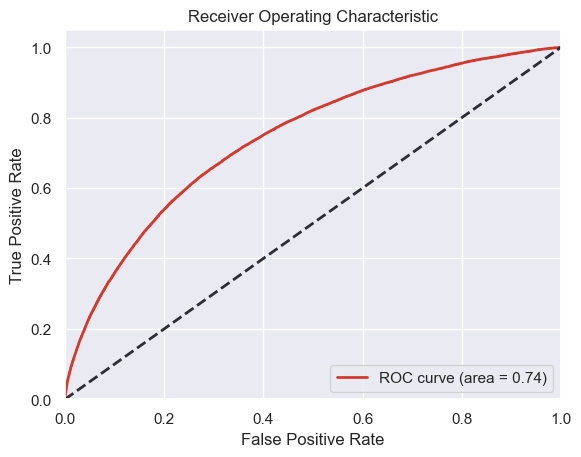

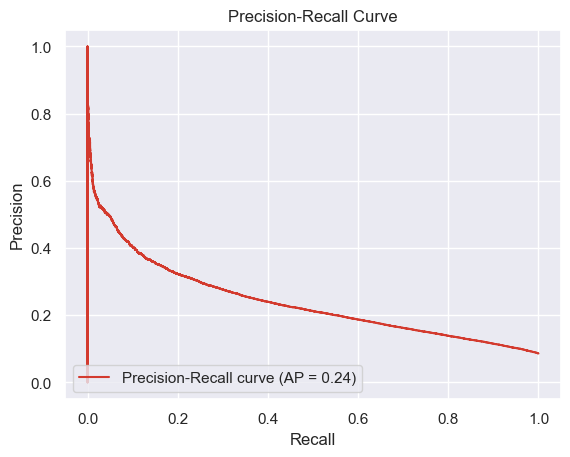

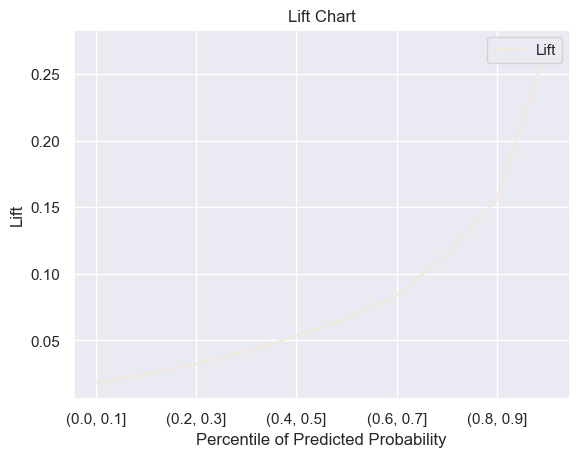

In [ ]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga', random_state=42)
eval_model(lr, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test, threshold=0.42)

[LightGBM] [Info] Number of positive: 92505, number of negative: 980109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 1072614, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Train AUC: 0.7742550157116174
Test AUC: 0.7652210272046451
Train Recall: 0.8067996324522999
Test Recall: 0.7894275985081888
Train Precision: 0.15440650123925737
Test Precision: 0.1532302230279682
Train F1-Score: 0.259205812533971
Test F1-Score: 0.25664491233249337
Train F2-Score: 0.4372818951596838
Test F2-Score: 0.43129139366191943
Train Accuracy: 0.6022865634794996
Test Accuracy: 0.6056094579891984

Confusion Matrix (Test):


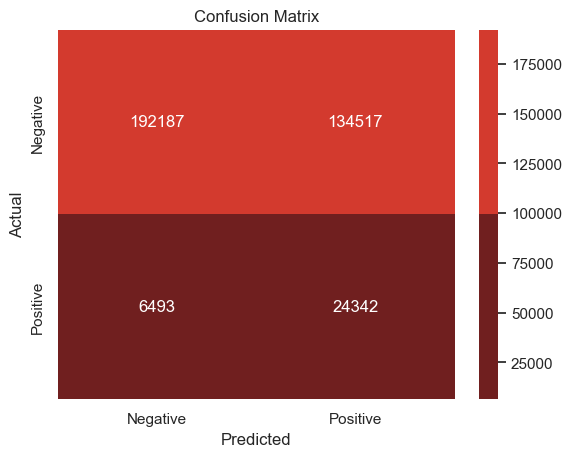


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.59      0.73    326704
           1       0.15      0.79      0.26     30835

    accuracy                           0.61    357539
   macro avg       0.56      0.69      0.49    357539
weighted avg       0.90      0.61      0.69    357539



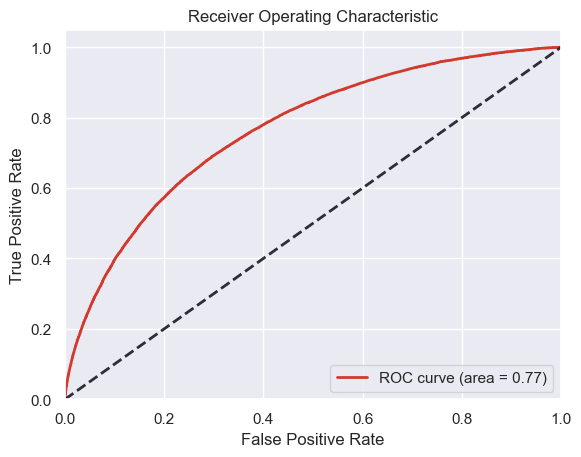

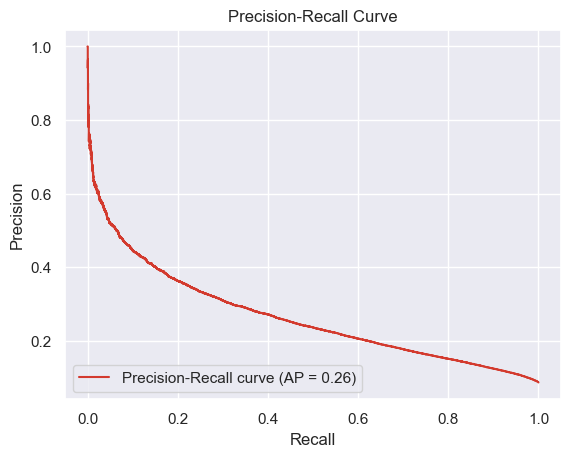

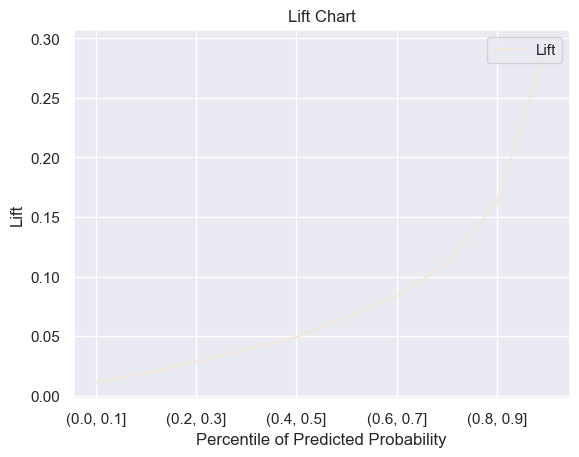

In [ ]:
# initialize the lightgbm classifier
lgbm = LGBMClassifier(random_state=42, class_weight='balanced')

eval_model(lgbm, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test, threshold=0.42)

From 2 model (Logistic Regression and LightGBM), we can see that LightGBM model has better performance than Logistic Regression model, from the AUC score, and the Precision Score.

## Hyperparameter Tuning

In [ ]:
# from sklearn.metrics import make_scorer, fbeta_score
# from sklearn.model_selection import RandomizedSearchCV
# from lightgbm import LGBMClassifier

# # Buat custom scorer untuk F2-Score
# f2_scorer = make_scorer(fbeta_score, beta=2)

# # Definisikan parameter grid
# param_grid = {
#     'num_leaves': [int(x) for x in np.linspace(start=20, stop=150, num=10)],
#     'max_depth': [int(x) for x in np.linspace(5, 30, num=6)]
# }

# # Inisialisasi model
# lgbm = LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# # Randomized search dengan custom scorer
# random_search = RandomizedSearchCV(
#     estimator=lgbm,
#     param_distributions=param_grid,
#     n_iter=100,
#     scoring=f2_scorer,  # custom scorer
#     cv=3,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit ke data training
# random_search.fit(Xtrain_selected_woe, y_train)

# # Tampilkan parameter terbaik
# print("Best parameters found: ", random_search.best_params_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits


KeyboardInterrupt: 

In [ ]:
# hyperparameter tuning lightgbm
num_leaves = [int(x) for x in np.linspace(start=20, stop=150, num=10)]
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]

# Create the random grid
random_grid = {'num_leaves': num_leaves,
               'max_depth': max_depth}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
lgbm = LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
lgbm_result = RandomizedSearchCV(estimator=lgbm, param_distributions=random_grid, n_iter=100, cv=3, random_state=42)

# print the best parameters
lgbm_result.fit(Xtrain_selected_woe, y_train)
lgbm_result.best_params_

[LightGBM] [Info] Number of positive: 61670, number of negative: 653406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 715076, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

{'num_leaves': 150, 'max_depth': 30}

{'num_leaves': 150, 'max_depth': 30}  best tune lgbm

In [ ]:
# logistic regression hyperparameter tuning
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear', 'saga']

# Create the random grid
random_grid = {'penalty': penalty,
               'C': C,
               'solver': solver}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
lr = LogisticRegression(random_state=42, class_weight='balanced')
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
lr_result = RandomizedSearchCV(estimator=lr, param_distributions=random_grid, n_iter=100, cv=3, random_state=42)

# print the best parameters
lr_result.fit(Xtrain_selected_woe, y_train)
lr_result.best_params_

{'solver': 'saga', 'penalty': 'l2', 'C': 100}

{'solver': 'saga', 'penalty': 'l2', 'C': 100}

Train AUC: 0.7413681403451919
Test AUC: 0.7419995332223197
Train Recall: 0.7875141884222474
Test Recall: 0.7862169612453381
Train Precision: 0.14178970847557915
Test Precision: 0.14258072104922662
Train F1-Score: 0.2403119314779964
Test F1-Score: 0.24138600552609962
Train F2-Score: 0.4121341657973166
Test F2-Score: 0.41318130688209426
Train Accuracy: 0.5705920303109973
Test Accuracy: 0.573811528252862

Confusion Matrix (Test):


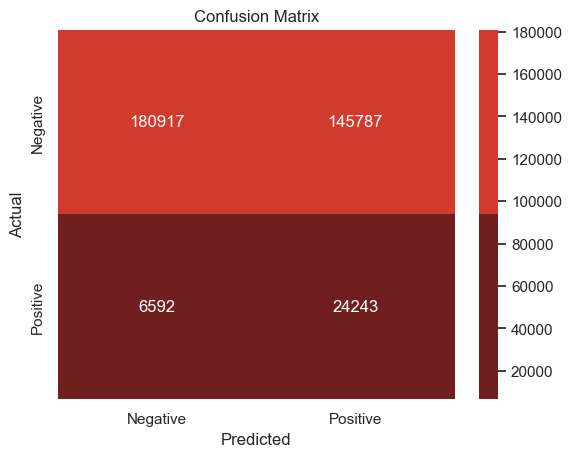


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.55      0.70    326704
           1       0.14      0.79      0.24     30835

    accuracy                           0.57    357539
   macro avg       0.55      0.67      0.47    357539
weighted avg       0.89      0.57      0.66    357539



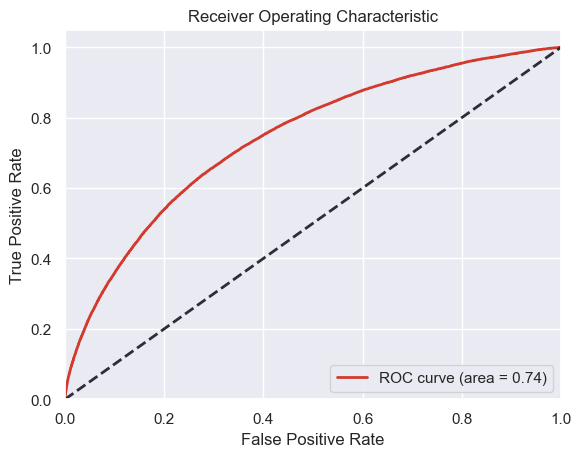

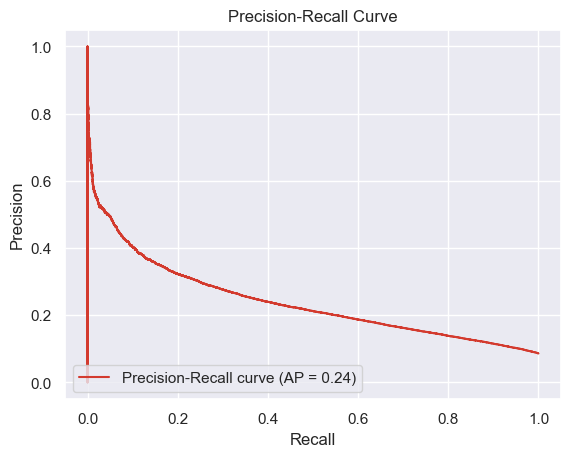

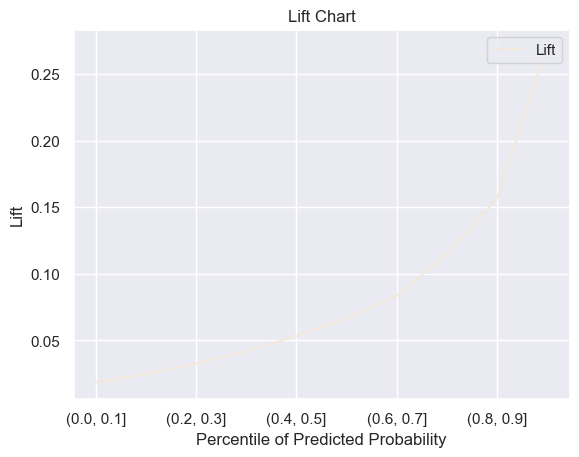

In [ ]:
# Assgn the best parameters to logistic regression
lr_tuned = LogisticRegression(random_state=42, class_weight='balanced', **lr_result.best_params_)
eval_model(lr_tuned, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test, threshold=0.42)

## Model Evaluation

Train AUC: 0.7413681403451919
Test AUC: 0.7419995332223197
Train Recall: 0.7875141884222474
Test Recall: 0.7862169612453381
Train Precision: 0.14178970847557915
Test Precision: 0.14258072104922662
Train F1-Score: 0.2403119314779964
Test F1-Score: 0.24138600552609962
Train F2-Score: 0.4121341657973166
Test F2-Score: 0.41318130688209426
Train Accuracy: 0.5705920303109973
Test Accuracy: 0.573811528252862

Confusion Matrix (Test):


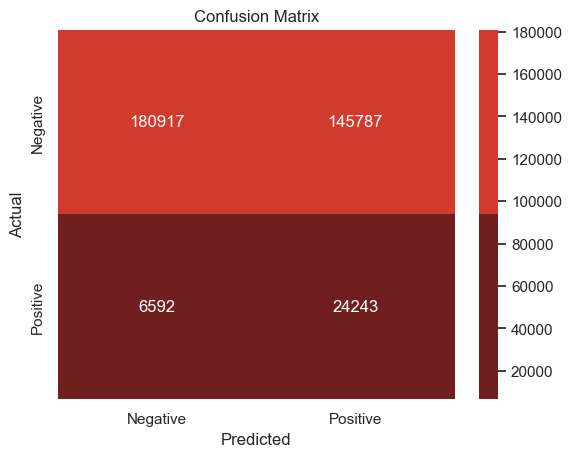


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.55      0.70    326704
           1       0.14      0.79      0.24     30835

    accuracy                           0.57    357539
   macro avg       0.55      0.67      0.47    357539
weighted avg       0.89      0.57      0.66    357539



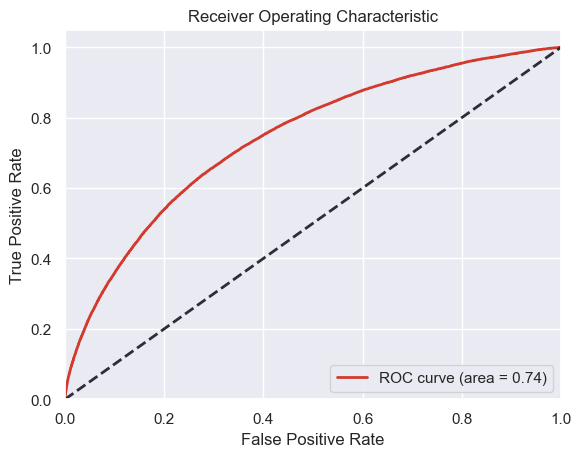

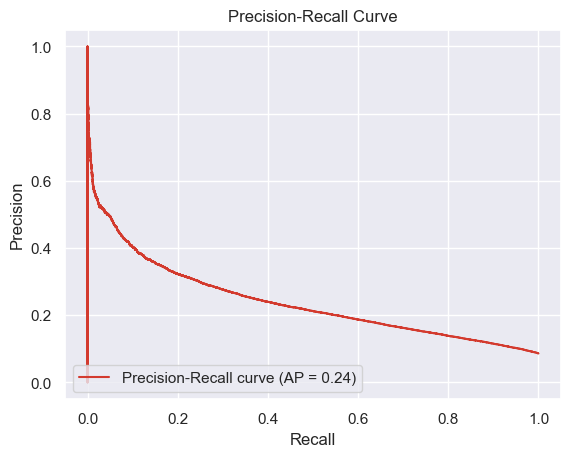

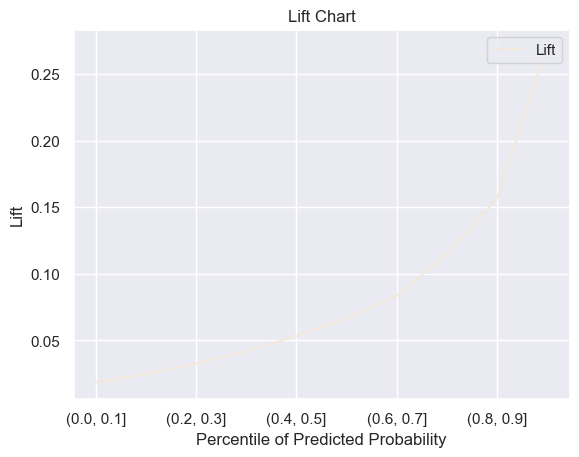

In [ ]:
# Assgn the best parameters to logistic regression
lr_tuned = LogisticRegression(random_state=42, class_weight='balanced', **lr_result.best_params_)
eval_model(lr_tuned, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test, threshold=0.42)

In [ ]:
class_weight='balanced'{'num_leaves': 150, 'max_depth': 30}

[LightGBM] [Info] Number of positive: 92505, number of negative: 980109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 1072614, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Train AUC: 0.847856548170824
Test AUC: 0.8124211255230964
Train Recall: 0.863672233933301
Test Recall: 0.8085616993676018
Train Precision: 0.18789480863393274
Test Precision: 0.179665487248593
Train F1-Score: 0.3086432391817056
Test F1-Score: 0.2940024999410391
Train F2-Score: 0.5023351852177872
Test F2-Score: 0.475603661072302
Train Accuracy: 0.666307730460352
Test Accuracy: 0.665099471666028

Confusion Matrix (Test):


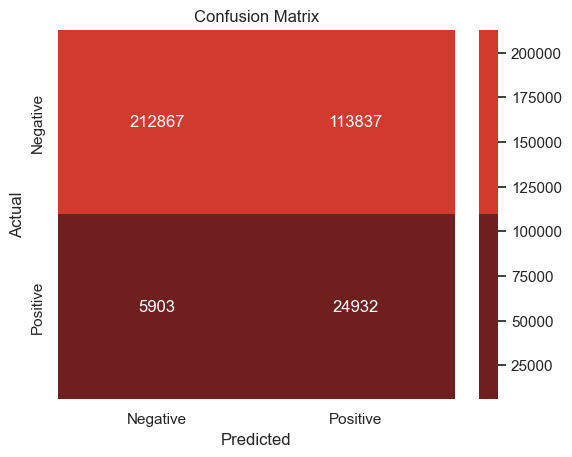


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.65      0.78    326704
           1       0.18      0.81      0.29     30835

    accuracy                           0.67    357539
   macro avg       0.58      0.73      0.54    357539
weighted avg       0.90      0.67      0.74    357539



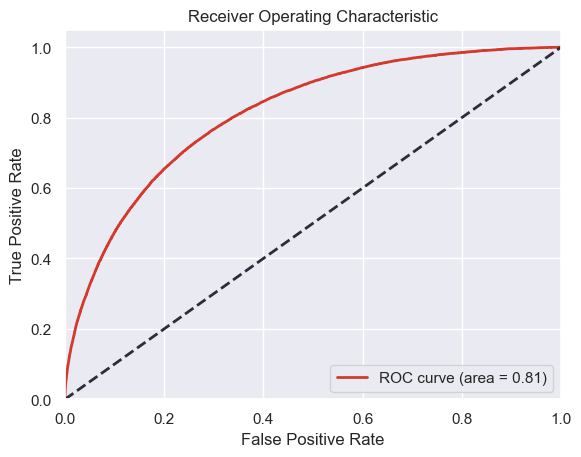

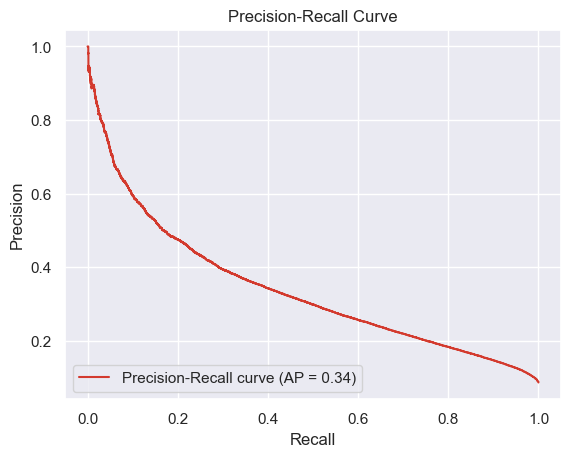

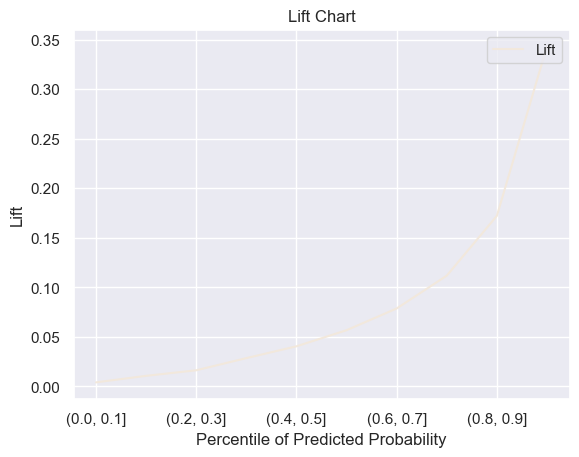

In [ ]:
# assign best hyperparameter to lightgbm
lgbm_tuned = LGBMClassifier(random_state=1130, class_weight='balanced', **lgbm_result.best_params_)
eval_model(lgbm_tuned, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test, threshold=0.42)

In [ ]:
def df_model_score(model, X_train, y_train, X_test, y_test, threshold):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_predict_proba = model.predict_proba(X_train)[:, 1]
    test_predic_proba = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, train_preds)
    test_auc = roc_auc_score(y_test, test_preds)

    train_recall = recall_score(y_train, train_predict_proba > threshold)
    test_recall = recall_score(y_test, test_predic_proba > threshold)

    return train_auc, test_auc, train_recall, test_recall

# Assgn the best parameters to logistic regression
lr_tuned = LogisticRegression(random_state=1103, class_weight='balanced', **lr_result.best_params_)
# assign best hyperparameter to lightgbm
lgbm_tuned = LGBMClassifier(random_state=1130, class_weight='balanced', **lgbm_result.best_params_)

# Evaluate the models and store the scores
lgbm_scores = df_model_score(lgbm_tuned, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test, threshold=0.42)
lr_scores = df_model_score(lr_tuned, X_train=Xtrain_selected_woe, y_train=y_train, X_test=Xtest_selected_woe, y_test=y_test, threshold=0.42)

# Create a DataFrame to store the scores
scores_df = pd.DataFrame(data=[lgbm_scores, lr_scores],
                         columns=['Train AUC', 'Test AUC', 'Train Recall', 'Test Recall'],
                         index=['LGBM', 'Logistic Regression'])

scores_df

[LightGBM] [Info] Number of positive: 92505, number of negative: 980109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 1072614, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,Train AUC,Test AUC,Train Recall,Test Recall
LGBM,0.763358,0.732437,0.863672,0.808562
Logistic Regression,0.679008,0.679848,0.787493,0.786185


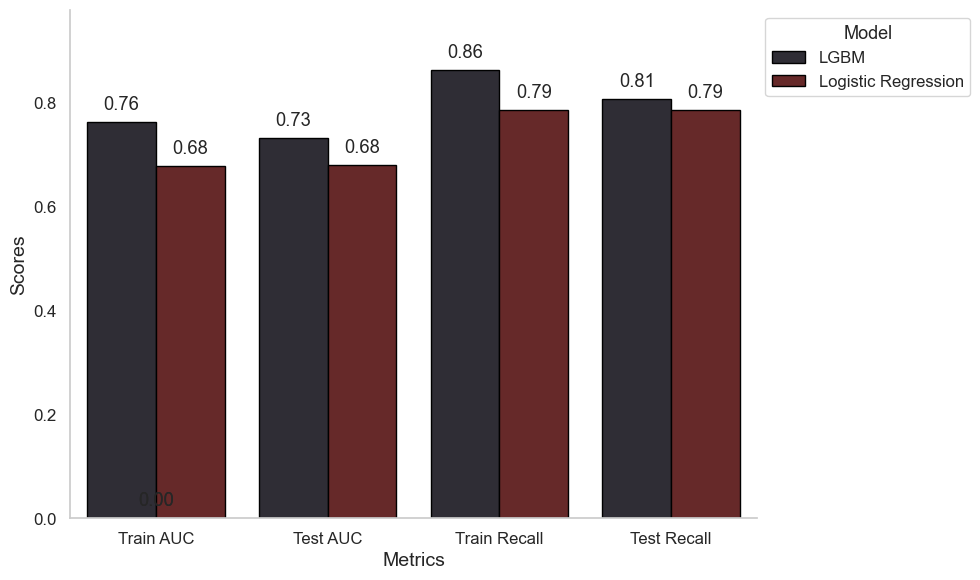

In [ ]:
# Panggil palette
palette = get_custom_palette()

# Ubah DataFrame ke format long (untuk seaborn)
long_scores_df = scores_df.reset_index().melt(id_vars='index', var_name='Metrics', value_name='Scores')

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")  # Background putih

# Buat barplot
barplot = sns.barplot(
    x='Metrics',
    y='Scores',
    hue='index',
    data=long_scores_df,
    palette=palette,
    edgecolor='black'
)

# Tambahkan anotasi ke tiap bar
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     xytext=(0, 6),
                     textcoords='offset points')

# Label dan styling
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.xticks(fontsize=12)
plt.ylim(0, 0.98)
plt.grid(False)
plt.legend(title='Model', title_fontsize=13, fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')

# HILANGKAN garis kanan dan atas
sns.despine(right=True, top=True)

plt.tight_layout()
plt.show()

## Confusion Matrix

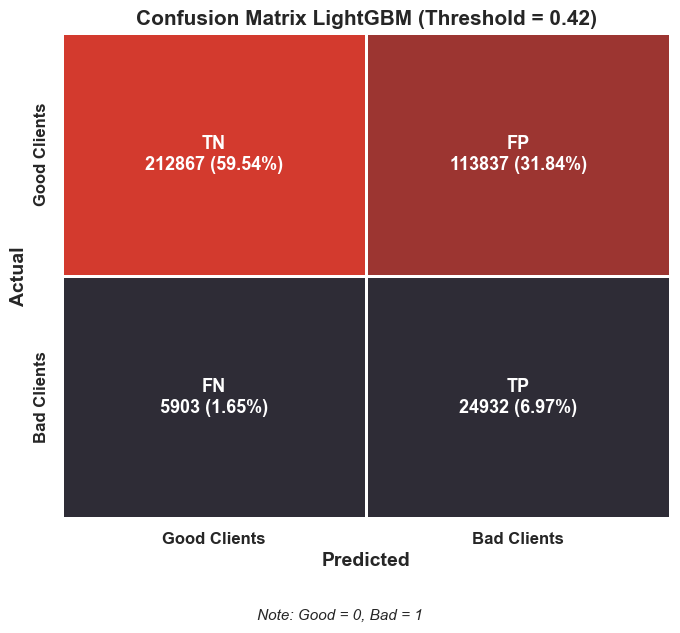

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Prediksi probabilitas dan ambil threshold 0.42
pred_test = lgbm_tuned.predict_proba(Xtest_selected_woe)[:, 1]
cnf_matrix = confusion_matrix(y_test, pred_test > 0.42)

# Hitung persentase
percentage_matrix = cnf_matrix / cnf_matrix.sum()

# Label kategori
labels = np.array([['TN', 'FP'],
                   ['FN', 'TP']])
annot_labels = (np.array([
    f"{label}\n{value} ({pct:.2%})"
    for label, value, pct in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())
])).reshape(2, 2)

# Custom colormap dari palette Anda
colors = ['#2E2C36', '#D33A2E']  # Dark Gray untuk Good, Bright Red untuk Bad
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=4)

# Plot
plt.figure(figsize=(7, 6))
sns.heatmap(
    cnf_matrix, annot=annot_labels, fmt='', cmap=custom_cmap, cbar=False,
    annot_kws={"weight": "bold", "size": 13}, linewidths=2, linecolor='white',
    xticklabels=['Good Clients', 'Bad Clients'],
    yticklabels=['Good Clients', 'Bad Clients']
)

# Styling
plt.xlabel('Predicted', fontsize=14, weight='bold')
plt.ylabel('Actual', fontsize=14, weight='bold')
plt.title('Confusion Matrix LightGBM (Threshold = 0.42)', fontsize=15, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

# Keterangan bawah
plt.figtext(0.5, -0.05, 'Note: Good = 0, Bad = 1',
            wrap=True, horizontalalignment='center', fontsize=11, style='italic')

plt.tight_layout()
plt.show()



In [ ]:
# Define the initial variables
tp = 24932  # true positives
fn = 5903  # false negatives
total_clients = 1430153
total_clients_test = 357539
total_bad_clients_before = 123340
avg_loan = 500000  # average loan

# Calculate the default rate before the model
dr_before_model = total_bad_clients_before / total_clients
print(f'Total bad clients before model: {total_bad_clients_before}')
print(f'\nDefault rate before model: {dr_before_model}%')

# Calculate the default rate after the model
dr_after_model = ((0.5 * tp) + fn) / total_clients_test
print(f'Default rate after model: {round(dr_after_model * 100, 1)}%')

# Calculate the decrease in default rate
decreased_dr = dr_after_model - dr_before_model
print(f'Decreased default rate: {round(decreased_dr * 100, 1)}%')

# Calculate the total bad clients after the model
total_bad_clients_after = dr_after_model * total_clients
print(f'\nTotal bad clients after model: {round(total_bad_clients_after)}')

# Calculate the decrease in bad clients
decreased_bad_clients = total_bad_clients_after - total_bad_clients_before
print(f'Decreased bad clients: {round(decreased_bad_clients)}')

# Calculate the total good clients before the model
total_good_clients_before = total_clients - total_bad_clients_before

# Calculate the total revenue, bad debt and net revenue before the model
tr_before = total_good_clients_before * avg_loan
total_bad_debt_before = total_bad_clients_before * avg_loan
net_revenue_before = tr_before - total_bad_debt_before
print('\nTotal Revenue before model:', round(tr_before))
print(f'Total bad debt before model: {round(total_bad_debt_before)}')
print(f'Net revenue before model: {round(net_revenue_before)}')

# Calculate the total good clients after the model
total_good_clients_after = total_clients - total_bad_clients_after

# Calculate the total revenue, bad debt and net revenue after the model
total_bad_debt_after = total_bad_clients_after * avg_loan
tr_after = total_good_clients_after * avg_loan
net_revenue_after = tr_after - total_bad_debt_after
print('\nTotal Revenue after model:', round(tr_after))
print(f'Total bad debt after model: {round(total_bad_debt_after)}')
print(f'Net revenue after model: {round(net_revenue_after)}')

net_revenue_increase = net_revenue_after - net_revenue_before
print(f'\nNet revenue increase: {round(net_revenue_increase)}')

Total bad clients before model: 123340

Default rate before model: 0.08624252090510595%
Default rate after model: 5.1%
Decreased default rate: -3.5%

Total bad clients after model: 73476
Decreased bad clients: -49864

Total Revenue before model: 653406500000
Total bad debt before model: 61670000000
Net revenue before model: 591736500000

Total Revenue after model: 678338577064
Total bad debt after model: 36737922936
Net revenue after model: 641600654129

Net revenue increase: 49864154129


## Feature Importances (LGBM)

In [ ]:
# Get feature importances
importances = lgbm_tuned.feature_importances_

# Create a DataFrame for feature importances
feat_importances = pd.DataFrame({'Feature': Xtrain_selected_woe.columns, 'Importance': importances})

# Sort by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
feat_importances_sorted = feat_importances.sort_values(by='Importance', ascending=True)

# Define the number of top features you want to highlight
top_features = 5

# Create a color list, where the highest feature importance is highlighted in a different color
colors = ['skyblue' if (x < sorted(feat_importances_sorted['Importance'], reverse=True)[top_features-1]) else 'red' for x in feat_importances_sorted['Importance']]

plt.barh(feat_importances_sorted['Feature'], feat_importances_sorted['Importance'], color=colors)
sns.despine()
plt.grid(False)
plt.xlabel('Importance')
plt.title('Feature Importances', y=1.07)
plt.show()

NameError: name 'lgbm_tuned' is not defined

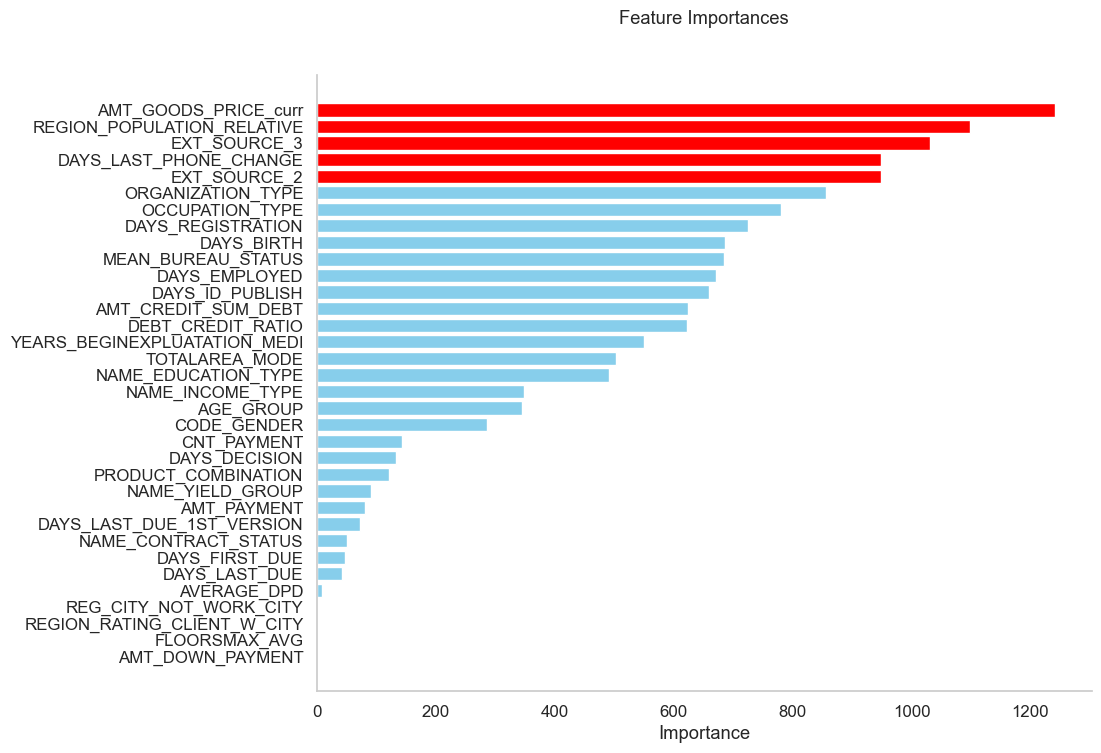

In [ ]:
# Get feature importances
importances = lgbm_tuned.feature_importances_

# Create a DataFrame for feature importances
feat_importances = pd.DataFrame({'Feature': Xtrain_selected_woe.columns, 'Importance': importances})

# Sort by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
feat_importances_sorted = feat_importances.sort_values(by='Importance', ascending=True)

# Define the number of top features you want to highlight
top_features = 5

# Create a color list, where the highest feature importance is highlighted in a different color
colors = ['skyblue' if (x < sorted(feat_importances_sorted['Importance'], reverse=True)[top_features-1]) else 'red' for x in feat_importances_sorted['Importance']]

plt.barh(feat_importances_sorted['Feature'], feat_importances_sorted['Importance'], color=colors)
sns.despine()
plt.grid(False)
plt.xlabel('Importance')
plt.title('Feature Importances', y=1.07)
plt.show()

In [ ]:
# Create a TreeExplainer
explainer = shap.TreeExplainer(lgbm_tuned)

# Calculate SHAP values
shap_values = explainer.shap_values(Xtrain_selected_woe)

In [ ]:
# Cek bentuk array
print(type(shap_values), len(shap_values))
print(np.shape(shap_values[0]), np.shape(shap_values[1]))  # jika binary classification

# Plot summary SHAP untuk kelas 1 (biasanya untuk target=1, yaitu bad clients misalnya)
shap.summary_plot(shap_values[1], Xtrain_selected_woe)

<class 'numpy.ndarray'> 1072614
(34,) (34,)


AssertionError: Summary plots need a matrix of shap_values, not a vector.

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.summary_plot(shap_values, Xtrain_selected_woe)

KeyboardInterrupt: 

In [ ]:
print(np.shape(Xtrain_selected_woe))  # seharusnya (n_samples, n_features)

(1072614, 34)


In [ ]:
scorecard.Classification.value_counts()

Classification
bad     821172
good    251442
Name: count, dtype: int64